In [10]:
# ================================================================
# 🧠 EDA_FN_FP_v2.ipynb
# Análisis de falsos negativos y falsos positivos – Fase 2
# ================================================================
# Autor: Alexis Zapico Fernández
# Fecha: 2025-10-28
# Descripción:
# Este notebook analiza los errores del modelo (FN y FP) en la fase v2,
# para identificar patrones nuevos en campañas phishing o legítimas mal clasificadas.
# ================================================================

# --- 0️⃣ Imports y configuración ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from urllib.parse import urlparse
from collections import Counter

pd.set_option('display.max_colwidth', 120)
plt.rcParams['figure.figsize'] = (10, 5)
sns.set(style="whitegrid")

# --- 1️⃣ Cargar datasets ---
preds_path = "../outputs/inclusion_v2/predicciones_inclusion_v2.csv"
fn_path = "../outputs/inclusion_v2/falsos_negativos_priorizados.csv"

df_preds = pd.read_csv(preds_path)
df_fn = pd.read_csv(fn_path)

print(f"✅ Predicciones cargadas: {len(df_preds)} filas")
print(f"✅ Falsos negativos cargados: {len(df_fn)} filas")

# --- 2️⃣ Identificar falsos positivos (FP) ---
df_fp = df_preds[(df_preds["label"] == 0) & (df_preds["pred_label"] == 1)].copy()
print(f"🔍 Falsos positivos detectados: {len(df_fp)}")

# --- 3️⃣ Resumen global de errores ---
summary = pd.DataFrame({
    "Tipo": ["Falsos negativos", "Falsos positivos"],
    "Cantidad": [len(df_fn), len(df_fp)],
    "Porcentaje": [len(df_fn) / len(df_preds) * 100, len(df_fp) / len(df_preds) * 100]
})
summary


✅ Predicciones cargadas: 300 filas
✅ Falsos negativos cargados: 25 filas
🔍 Falsos positivos detectados: 18


,Tipo,Cantidad,Porcentaje
0,Falsos negativos,25,8.333333
1,Falsos positivos,18,6.000000


In [11]:
# --- 4️⃣ Funciones auxiliares ---
def extract_domain(url):
    try:
        return urlparse(str(url)).netloc.lower()
    except:
        return ""

def extract_tld(url):
    try:
        parts = urlparse(str(url)).netloc.split(".")
        return parts[-1] if len(parts) > 1 else ""
    except:
        return ""

df_fn["domain"] = df_fn["url"].apply(extract_domain)
df_fp["domain"] = df_fp["url"].apply(extract_domain)
df_fn["tld"] = df_fn["url"].apply(extract_tld)
df_fp["tld"] = df_fp["url"].apply(extract_tld)



In [12]:
# --- 5️⃣ Distribución por sector y entidad ---
if "sector" in df_fn.columns:
    print("📊 Falsos negativos por sector:")
    display(df_fn["sector"].value_counts(normalize=True).mul(100).round(2))
if "entidad" in df_fn.columns:
    print("\n🏦 Entidades más afectadas en FN:")
    display(df_fn["entidad"].value_counts().head(10))

if "sector" in df_fp.columns:
    print("\n📊 Falsos positivos por sector:")
    display(df_fp["sector"].value_counts(normalize=True).mul(100).round(2))


📊 Falsos negativos por sector:


sector
Genérico / Otros    44.0
Banca               32.0
Logística           24.0
Name: proportion, dtype: float64


🏦 Entidades más afectadas en FN:


entidad
Generico     13
Correos       5
Santander     3
CaixaBank     2
BBVA          2
Name: count, dtype: int64


📊 Falsos positivos por sector:


sector
Banca                         22.22
SaaS / Cloud / Plataformas    22.22
Público / Administración      22.22
Cripto / Fintech              16.67
Logística                      5.56
Energía / Seguros              5.56
Genérico / Otros               5.56
Name: proportion, dtype: float64

/var/folders/fc/53j7mrrs40j5jvl09zqzrcqw0000gn/T/ipykernel_54218/3344495897.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=tld_fn.index, y=tld_fn.values, ax=ax[0], palette="Reds_r")
/var/folders/fc/53j7mrrs40j5jvl09zqzrcqw0000gn/T/ipykernel_54218/3344495897.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=tld_fp.index, y=tld_fp.values, ax=ax[1], palette="Blues_r")


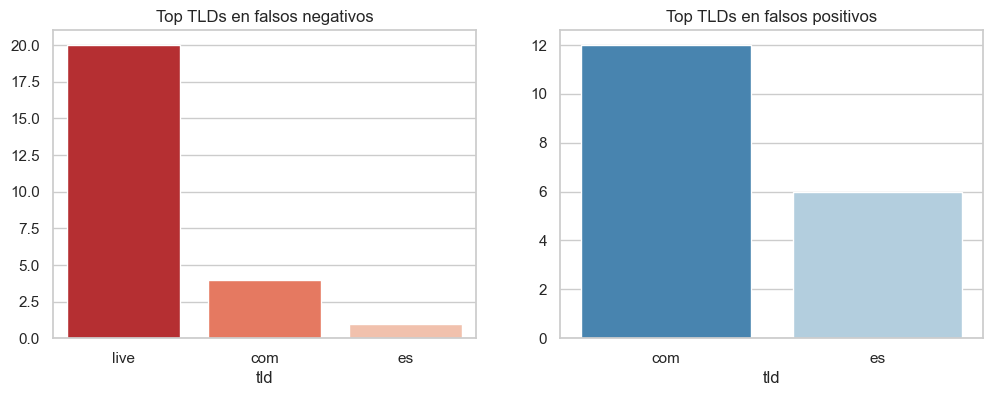

In [13]:
# --- 6️⃣ Análisis de TLD ---
tld_fn = df_fn["tld"].value_counts().head(10)
tld_fp = df_fp["tld"].value_counts().head(10)

fig, ax = plt.subplots(1, 2, figsize=(12, 4))
sns.barplot(x=tld_fn.index, y=tld_fn.values, ax=ax[0], palette="Reds_r")
ax[0].set_title("Top TLDs en falsos negativos")
sns.barplot(x=tld_fp.index, y=tld_fp.values, ax=ax[1], palette="Blues_r")
ax[1].set_title("Top TLDs en falsos positivos")
plt.show()


In [14]:
# --- 7️⃣ Tokens en rutas ---
def extract_tokens(url):
    path = urlparse(str(url)).path.lower()
    return [t for t in path.split("/") if len(t) > 3]

def get_common_tokens(df, n=15):
    all_tokens = []
    for u in df["url"].dropna():
        all_tokens.extend(extract_tokens(u))
    return Counter(all_tokens).most_common(n)

tokens_fn = get_common_tokens(df_fn)
tokens_fp = get_common_tokens(df_fp)

print("🧩 Tokens más comunes en falsos negativos:")
display(pd.DataFrame(tokens_fn, columns=["token", "count"]))

print("\n🧩 Tokens más comunes en falsos positivos:")
display(pd.DataFrame(tokens_fp, columns=["token", "count"]))


🧩 Tokens más comunes en falsos negativos:


,token,count
0,login.php,14
1,clients,12
2,acceso,8
3,login,3
4,home,3
5,correos,2
6,bbva_light,2
7,recibir_paquete.php,2
8,santa_presi,1
9,aviso,1



🧩 Tokens más comunes en falsos positivos:


,token,count
0,sede,5
1,particular,2
2,portal,2
3,home,1
4,particulares_es.html,1
5,atencioclient,1
6,faqs,1
7,accesolo_faq1_es.html,1
8,satellite,1
9,sabatl,1


📈 Comparando medias de features en FN / FP / aciertos...


error_type,FN,FP,OK
confianza,90.000000,NaN,90.000000
score_total_v2,13.720000,NaN,14.432000
ruido,10.000000,NaN,10.000000
domain_length,4.240000,10.833333,7.011673
domain_entropy,1.850697,2.963892,2.308882
inclusion,1.000000,NaN,1.000000
protocol,1.000000,1.000000,0.867704
trusted_path_token,0.680000,0.000000,0.159533
suspicious_path_token,0.640000,0.222222,0.490272
prob_phish,0.233749,0.610852,0.453955


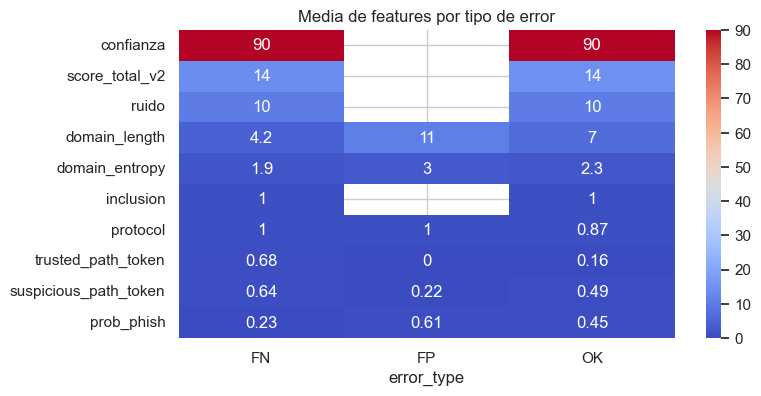

In [15]:
# --- 8️⃣ Comparativa de features numéricas (si existen) ---
numeric_cols = [
    c for c in df_preds.columns
    if df_preds[c].dtype != "object" and c not in ["label", "pred_label"]
]

if numeric_cols:
    print("📈 Comparando medias de features en FN / FP / aciertos...")
    df_preds["error_type"] = np.select(
        [
            (df_preds["label"] == 1) & (df_preds["pred_label"] == 0),
            (df_preds["label"] == 0) & (df_preds["pred_label"] == 1),
        ],
        ["FN", "FP"],
        default="OK",
    )

    feature_means = (
        df_preds.groupby("error_type")[numeric_cols]
        .mean()
        .T.sort_values(by=["FN"], ascending=False)
    )
    display(feature_means.head(15))

    plt.figure(figsize=(8, 4))
    sns.heatmap(feature_means.head(10), annot=True, cmap="coolwarm")
    plt.title("Media de features por tipo de error")
    plt.show()
